In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import csv
import numpy as np

# Read runtimes from logfiles

In [3]:
def read_logfile(logfile):
    runtimes_dict = []
    header = None
    with open(logfile, 'r') as f:
        for line in csv.reader(f):
            if header is None:
                header = line
            else:
                runtime_dict = {}
                for (header_elem, line_elem) in zip(header, line):
                    if header_elem != 'scenario':
                        if line_elem == '':
                            runtime_dict[header_elem] = None
                        else:
                            runtime_dict[header_elem] = float(line_elem)
                    else:
                        runtime_dict[header_elem] = line_elem
                runtimes_dict.append(runtime_dict)
    return runtimes_dict

import json
import os
import re
def read_real_system_runtimes(parent_dir):
    runtimes_dict = []
    tot_count = 0.
    count_failing_strict = 0.
    count_failing = 0.
    for sub_dir in os.listdir(parent_dir):
        m = re.match(r'(.*),model=(.*)(,.*)?', sub_dir)
        if m is not None:
            scenario = m.group(1)
            model = m.group(2)
            runtime_dict = {"scenario": scenario, "model": model}
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_stats.json")
            try:
                with open(full_logpath, 'r') as f:
                    all_instance_stats = json.load(f)
                    runtimes = []
                    idealized_runtimes = []
                    denoised_runtimes = []
                    for per_instance_stats in all_instance_stats:
                        stats = per_instance_stats["stats"]
                        runtime = None
                        num_output_tokens_in_per_instance_metrics = None
                        for stat in stats:
                            if stat["name"]["name"] == "inference_runtime":
                                if stat["count"] > 0:
                                    runtimes.append(stat["mean"])
                            elif stat["name"]["name"] == "inference_idealized_runtime":
                                if stat["count"] > 0:
                                    idealized_runtimes.append(stat["mean"])
                            elif stat["name"]["name"] == "inference_denoised_runtime":
                                if stat["count"] > 0:
                                    denoised_runtimes.append(stat["mean"])
                    runtime_dict["inference_runtime"] = np.mean(runtimes)
                    runtime_dict["inference_idealized_runtime"] = np.mean(idealized_runtimes)
                    runtime_dict["inference_denoised_runtime"] = np.mean(denoised_runtimes)
                    
                    tot_count += 1
                    if np.mean(denoised_runtimes) > np.mean(runtimes):
                        count_failing_strict += 1
                    if np.mean(denoised_runtimes) > 1.05 * np.mean(runtimes):
                        count_failing += 1
                        print(scenario, model, np.mean(runtimes), np.mean(denoised_runtimes))
                    
                    runtimes_dict.append(runtime_dict)
            except Exception as e:
                print(full_logpath, e)
    print(f"Fraction strict failing: {count_failing_strict / tot_count:.3f} "
          f"({count_failing_strict} / {tot_count})")
    print(f"Fraction weak failing: {count_failing / tot_count:.3f} "
          f"({count_failing} / {tot_count})")
        
    return runtimes_dict

In [4]:
runtimes_dict = read_real_system_runtimes("../benchmark_output/runs/latest")

/Users/deepak/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/deepak/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


math:subject=precalculus,level=1,use_official_examples=True,use_chain_of_thought=False openai_ada 0.15252008045292556 0.18253107569364993
civil_comments:demographic=muslim openai_babbage,data_augmentation=canonical 0.13089726879448382 0.14295787882125346
babi_qa:task=all openai_ada 0.1472866530418396 0.164640541015625
wikifact:k=5,subject=symptoms_and_signs cohere_small-20220720 0.21246554131631729 0.22431209415584413
summarization_xsum:temperature=0.3,device=cpu openai_babbage 0.2183428897857666 0.23949607552083335
math:subject=intermediate_algebra,level=1,use_official_examples=True,use_chain_of_thought=False openai_ada 0.15252008045292556 0.18253107569364993
blimp:phenomenon=quantifiers openai_babbage 0.09148120069503785 0.11124420703124997
math:subject=number_theory,level=1,use_official_examples=True,use_chain_of_thought=False openai_ada 0.15252008045292556 0.18253107569364993
civil_comments:demographic=male openai_ada,data_augmentation=canonical 0.12966895440144552 0.16513021580336

# Plot runtimes versus idealized runtimes for various models

In [5]:
import matplotlib.colors as mcolors
def plot_runtime_versus_estimated_runtime(runtimes_dict, label,
                                          y_metric_name,
                                          x_metric_name="inference_runtime",
                                          filter_fn=None,
                                          output_filename=None):
    print(label)
    fig = plt.figure(figsize=(10, 4.5))
    ax1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1)
    
    colors = {}
    all_colors = sorted(
        mcolors.CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    all_colors = all_colors[15:]
    color_index = 0
    
    models_displayed = set()
    violating_models = {}
    points = 0
    violating_points = 0
    for runtime_dict in runtimes_dict:
        model = runtime_dict['model'].split(",")[0]
        if model not in colors:
            colors[model] = all_colors[color_index]
            color_index += 1
        if filter_fn is None or filter_fn(runtime_dict):
            if model.startswith("openai"):
                color = 'green'
            elif model.startswith("ai21"):
                color = 'red'
            else:
                color = 'k'
            for ax in [ax1, ax2]:
                ax.scatter(runtime_dict[x_metric_name],
                           runtime_dict[y_metric_name],
                           marker='o', color=color, alpha=0.5)
            if runtime_dict[x_metric_name] is not None and \
                runtime_dict[y_metric_name] is not None:
                models_displayed.add(model)
                points += 1
                if runtime_dict[x_metric_name] < runtime_dict[y_metric_name]:
                    violating_points += 1
                    if model not in violating_models:
                        violating_models[model] = 0
                    violating_models[model] += 1
    print([(model, colors[model]) for model in models_displayed])
    print("Violating models:", violating_models)
    print("Violating points, points:", violating_points, points)
    for ax in [ax1, ax2]:
        ax.plot([0.1, 100], [0.1, 100], color='black', linestyle=':')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xlim(0.1, 20)
    ax2.set_ylim(0.1, 20)
    
    if x_metric_name == "inference_runtime":
        ax1.set_xlabel("Raw runtime (seconds)")
    elif x_metric_name == "inference_denoised_runtime":
        ax.set_xlabel("Denoised runtime (seconds)")
    if y_metric_name == "inference_denoised_runtime":
        ax1.set_ylabel("Denoised runtime\n(seconds)")
    elif y_metric_name == "inference_idealized_runtime":
        ax1.set_ylabel("Idealized runtime\n(seconds)")
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

All (denoised)
[('together_opt-175b', 'red'), ('openai_text-ada-001', 'firebrick'), ('ai21_j1-large', 'maroon'), ('together_t5-11b', 'navajowhite'), ('together_t0pp', 'darkorange'), ('openai_curie', 'burlywood'), ('openai_text-curie-001', 'seashell'), ('together_ul2', 'brown'), ('cohere_medium-20220720', 'mistyrose'), ('together_gpt-j-6b', 'tomato'), ('cohere_small-20220720', 'coral'), ('together_gpt-neox-20b', 'antiquewhite'), ('together_glm', 'tan'), ('cohere_large-20220720', 'saddlebrown'), ('ai21_j1-grande', 'darkred'), ('openai_code-davinci-002', 'indianred'), ('together_yalm', 'sandybrown'), ('ai21_j1-jumbo', 'salmon'), ('cohere_xlarge-20220609', 'lightcoral'), ('openai_code-cushman-001', 'orangered'), ('together_bloom', 'darksalmon'), ('openai_davinci', 'peru'), ('openai_babbage', 'bisque'), ('anthropic_stanford-online-all-v4-s3', 'sienna'), ('together_opt-66b', 'lightsalmon'), ('openai_text-davinci-002', 'linen'), ('openai_ada', 'chocolate'), ('openai_text-babbage-001', 'peachp

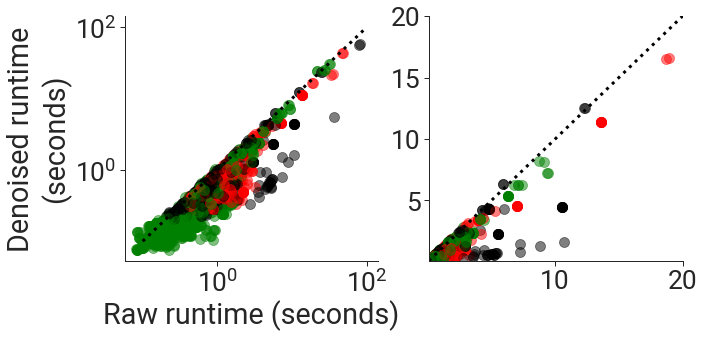

All (idealized)
[('together_opt-175b', 'red'), ('openai_text-ada-001', 'firebrick'), ('ai21_j1-large', 'maroon'), ('together_t5-11b', 'navajowhite'), ('together_t0pp', 'darkorange'), ('openai_curie', 'burlywood'), ('openai_text-curie-001', 'seashell'), ('together_ul2', 'brown'), ('cohere_medium-20220720', 'mistyrose'), ('together_gpt-j-6b', 'tomato'), ('cohere_small-20220720', 'coral'), ('together_gpt-neox-20b', 'antiquewhite'), ('together_glm', 'tan'), ('cohere_large-20220720', 'saddlebrown'), ('ai21_j1-grande', 'darkred'), ('openai_code-davinci-002', 'indianred'), ('together_yalm', 'sandybrown'), ('ai21_j1-jumbo', 'salmon'), ('cohere_xlarge-20220609', 'lightcoral'), ('openai_code-cushman-001', 'orangered'), ('together_bloom', 'darksalmon'), ('openai_davinci', 'peru'), ('openai_babbage', 'bisque'), ('anthropic_stanford-online-all-v4-s3', 'sienna'), ('together_opt-66b', 'lightsalmon'), ('openai_text-davinci-002', 'linen'), ('openai_ada', 'chocolate'), ('openai_text-babbage-001', 'peach

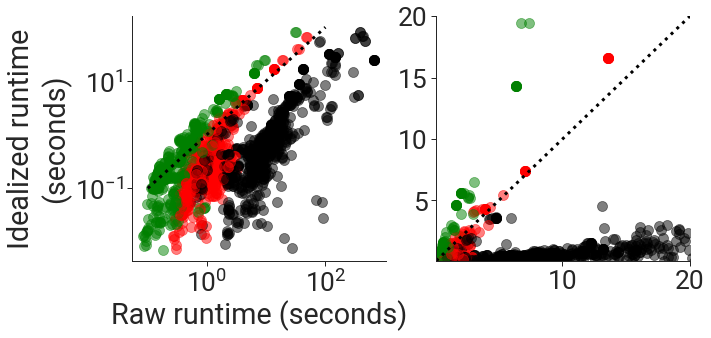

All (idealized)
[('together_opt-175b', 'red'), ('openai_text-ada-001', 'firebrick'), ('ai21_j1-large', 'maroon'), ('together_t5-11b', 'navajowhite'), ('together_t0pp', 'darkorange'), ('openai_curie', 'burlywood'), ('openai_text-curie-001', 'seashell'), ('together_ul2', 'brown'), ('cohere_medium-20220720', 'mistyrose'), ('together_gpt-j-6b', 'tomato'), ('cohere_small-20220720', 'coral'), ('together_gpt-neox-20b', 'antiquewhite'), ('together_glm', 'tan'), ('cohere_large-20220720', 'saddlebrown'), ('ai21_j1-grande', 'darkred'), ('openai_code-davinci-002', 'indianred'), ('together_yalm', 'sandybrown'), ('ai21_j1-jumbo', 'salmon'), ('cohere_xlarge-20220609', 'lightcoral'), ('openai_code-cushman-001', 'orangered'), ('together_bloom', 'darksalmon'), ('openai_davinci', 'peru'), ('openai_babbage', 'bisque'), ('anthropic_stanford-online-all-v4-s3', 'sienna'), ('together_opt-66b', 'lightsalmon'), ('openai_text-davinci-002', 'linen'), ('openai_ada', 'chocolate'), ('openai_text-babbage-001', 'peach

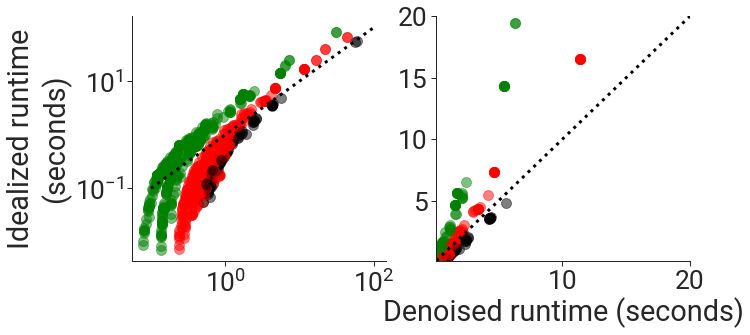

In [6]:
plot_runtime_versus_estimated_runtime(runtimes_dict, "All (denoised)",
                                      y_metric_name="inference_denoised_runtime",
                                      output_filename="../figures/runtime_vs_denoised_runtime/all_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "All (idealized)",
                                      y_metric_name="inference_idealized_runtime",
                                      output_filename="../figures/runtime_vs_idealized_runtime/all_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "All (idealized)",
                                      y_metric_name="inference_idealized_runtime",
                                      x_metric_name="inference_denoised_runtime",
                                      output_filename="../figures/idealized_vs_denoised_runtime/all_v2.pdf")